In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os, re
import random
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from itertools import groupby
from statistics import median
import matplotlib.pyplot as plt 

In [2]:
# For randomization and re-producability of results
random.seed(123)
np.random.seed(123)

In [4]:
data = None
with open('./data/snippets.cpkl', 'rb') as file:
    data = pkl.load(file)

In [5]:
run_results=pd.DataFrame(columns=['Classifier Name', 'Mean Fit Time(s)', 'Mean Test Time(s)', 
                                  'Mean Train Score', 'Mean CV Score', 'Best Test Score'])

In [6]:
print(type(data))
# The data is in the form of a dictionary
print("Keys : ", data.keys())
print("Total languages : ", len(data))

<class 'collections.defaultdict'>
Keys :  dict_keys(['fsharp', 'objc', 'haskell', 'csharp', 'go', 'smalltalk', 'xml', 'java', 'scala', 'ruby', 'delphi', 'perl', 'lua', 'json', 'html', 'matlab', 'ada', 'erlang', 'css', 'shell', 'python', 'javascript', 'dart', 'emacslisp', 'sql', 'php', 'swift', 'groovy', 'latex', 'c', 'visualbasic', 'lisp', 'r', 'fortran', 'cpp', 'awk', 'clojure', 'rust', 'prolog'])
Total languages :  39


In [7]:
tfIdf_traindata = []
train_data, test_data = [], []
for lang in data.keys():
    # we first get only a specific set of code snippets having length within a limited span.
    # This will help reduce the data and get an estimate of the model and its parameters.  
    filtered_code=sorted([code for code in data[lang] if 250<=len(code)<=500], 
                            key=lambda k:len(k), reverse=True)[:1000]
    n = int(len(filtered_code)*0.2)
    train_data.extend([(code,lang) for code in filtered_code[:-n]])
    test_data.extend([(code,lang) for code in filtered_code[-n:]])
    # we keep all the code mapped to any single language as a single big document.
    # The tf-Idf scoring will help to differentiate between languages better
    tfIdf_traindata.append('\n'.join(filtered_code[:-n]))

In [8]:
rgxPattern = re.compile(r'\w+|[^\w\s]')
def custom_tokenizer(text):
  tokenList = rgxPattern.findall(text)
  # This line merges same consecutive occurring tokens to form a single token. ===, ###, ++ 
  tokenList = [''.join(list(group)) for _,group in groupby(tokenList)]
  return tokenList

In [9]:
random.shuffle(train_data)
random.shuffle(test_data)

In [10]:
# Separte the code from the language
codeList_train, langList_train=map(list, zip(*train_data))
codeList_test, langList_test = map(list, zip(*test_data))

In [11]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
lbencoder = LabelEncoder()
lbencoder.fit(langList_train)

LabelEncoder()

In [13]:
tfidf = TfidfVectorizer( encoding='latin-1', sublinear_tf=True, 
                        token_pattern=None,
                        ngram_range=(1, 2), 
                        max_features=120000, 
                        #max_features=20000,
                        tokenizer=custom_tokenizer)

In [14]:
tfidf.fit(tfIdf_traindata)

TfidfVectorizer(encoding='latin-1', max_features=120000, ngram_range=(1, 2),
                sublinear_tf=True, token_pattern=None,
                tokenizer=<function custom_tokenizer at 0x000002285A208CA8>)

In [15]:
# Preparing X and Y for train and test set
X_train = tfidf.transform(codeList_train)
Y_train = lbencoder.transform(langList_train)
X_test = tfidf.transform(codeList_test)
Y_test = lbencoder.transform(langList_test)

In [16]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [17]:
def classifier_optimizer(classifier, params, cv_limit=3):
    gridClf = GridSearchCV(classifier, params, scoring='accuracy', 
                            n_jobs=-1, refit=True, cv=cv_limit, return_train_score=True)
    gridClf_result = gridClf.fit(X_train, Y_train).cv_results_
    print("Mean fit time : %.3fs" % gridClf_result['mean_fit_time'].mean())
    print("Mean test time : %.3fs" % gridClf_result['mean_score_time'].mean())
    print("Mean train score : %.3f" % gridClf_result['mean_train_score'].mean())
    print("Mean CV score : %.3f" % gridClf_result['mean_test_score'].mean())
    print("Best params : ", gridClf.best_params_)
    Y_pred = gridClf.predict(X_test)
    print("Test score for best params : %.3f" % accuracy_score(Y_test,Y_pred))
    return Y_pred

In [18]:
def draw_confusion_matrix(y_true, y_pred, labels):
    plt.figure(figsize=(14.0, 12.0))
    conf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    hMap = sns.heatmap(df_cm, annot=True, fmt='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

In [ ]:
# Logistic Regression

lr_clf = LogisticRegression(random_state=123, n_jobs=-1)
# not all the combination of hyperparams will be compatible so we define
# a list of params dict. First we fix the solver param, then go to fix C
lr_params = [{'penalty' : ['l2'], 'solver':['newton-cg', 'sag', 'lbfgs']}, 
             {'penalty' : ['elasticnet'], 'solver':['saga'], 
               'l1_ratio':[0, 0.25, 0.5, 0.75, 1]}]
Y_pred = classifier_optimizer(lr_clf, lr_params)

Mean fit time : 124.488s
Mean test time : 0.091s
Mean train score : 0.820
Mean CV score : 0.787
Best params :  {'l1_ratio': 0, 'penalty': 'elasticnet', 'solver': 'saga'}
[0.88168332 0.82112565 0.80234195 0.79676179 0.79731122]
Test score for best params : 0.803


In [ ]:
lr_clf = LogisticRegression(penalty='l2', solver='saga', 
                            random_state=123, n_jobs=-1)
lr_params = {'C': [0.01, 0.1, 1, 10, 100]}
Y_pred = classifier_optimizer(lr_clf, lr_params)

Mean fit time : 44.128s
Mean test time : 0.102s
Mean train score : 0.875
Mean CV score : 0.783
Best params :  {'C': 100}
Test score for best params : 0.824


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [77]:
run_results.loc[run_results.shape[0]]=['Logistic Regression', 44.128, 0.102, 
                                                0.875, 0.738, 0.824]

Confusion Matrix for best params :


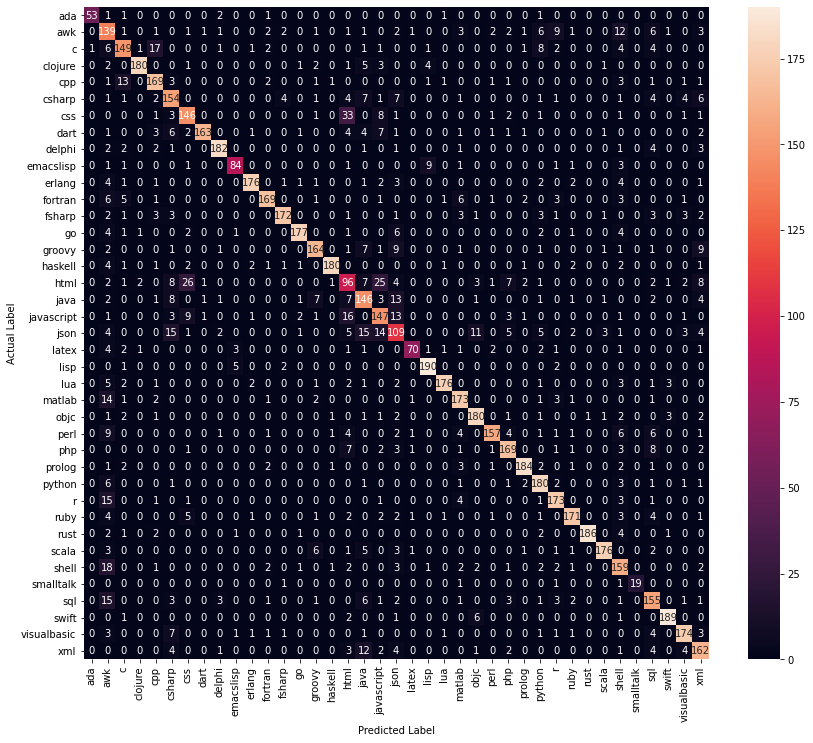

Classification Report for the best params : 
              precision    recall  f1-score   support

         ada       0.98      0.88      0.93        60
         awk       0.49      0.69      0.57       200
           c       0.78      0.74      0.76       200
     clojure       0.97      0.90      0.94       200
         cpp       0.80      0.84      0.82       200
      csharp       0.70      0.77      0.73       200
         css       0.74      0.73      0.73       200
        dart       0.98      0.81      0.89       200
      delphi       0.93      0.91      0.92       200
   emacslisp       0.88      0.82      0.85       103
      erlang       0.95      0.88      0.91       200
     fortran       0.91      0.84      0.88       200
      fsharp       0.93      0.86      0.90       200
          go       0.95      0.89      0.91       200
      groovy       0.86      0.82      0.84       200
     haskell       0.97      0.90      0.93       200
        html       0.49      0.48   

In [ ]:
print("Confusion Matrix for best params :")
draw_confusion_matrix(Y_test, Y_pred, lbencoder.classes_)
print("Classification Report for the best params : ")
print(classification_report(Y_test, Y_pred, target_names=lbencoder.classes_))

In [ ]:
# K Nearest Neighbour

knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_params = {'n_neighbors':[5,10,25,50], 'weights':['uniform','distance'], 
             'metric':['cosine']}
Y_pred = classifier_optimizer(knn_clf, knn_params)

Mean fit time : 0.037s
Mean test time : 21.517s
Mean train score : 0.908
Mean CV score : 0.788
Best params :  {'metric': 'cosine', 'n_neighbors': 10, 'weights': 'distance'}
Test score for best params : 0.798


In [78]:
run_results.loc[run_results.shape[0]]=['KNeighbors Classifier', 0.037, 21.517, 
                                                0.908, 0.788, 0.798]

Confusion Matrix for best params :


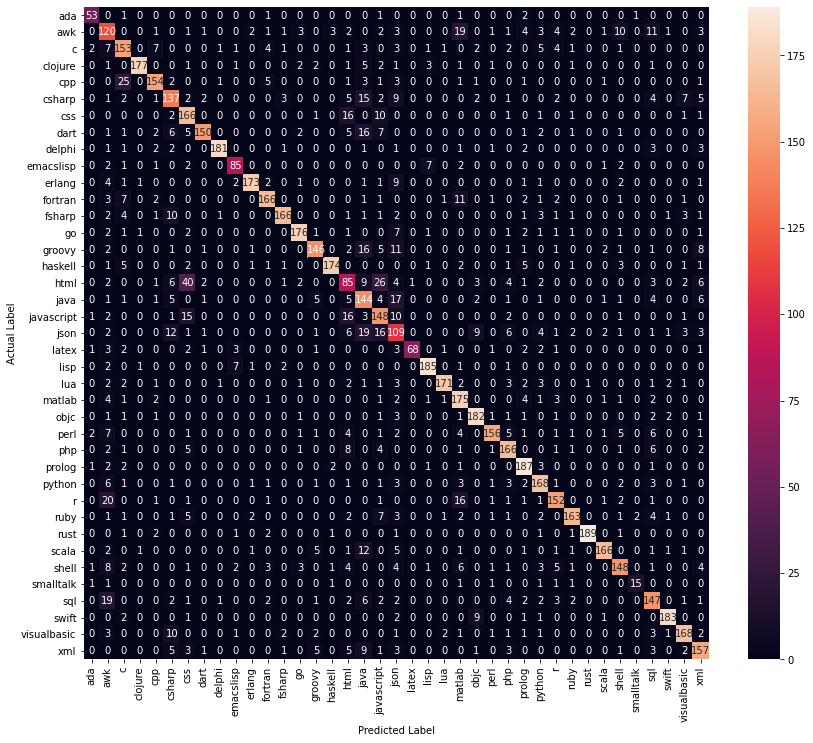

Classification Report for the best params : 
              precision    recall  f1-score   support

         ada       0.85      0.88      0.87        60
         awk       0.51      0.60      0.55       200
           c       0.70      0.77      0.73       200
     clojure       0.98      0.89      0.93       200
         cpp       0.86      0.77      0.81       200
      csharp       0.67      0.69      0.68       200
         css       0.65      0.83      0.73       200
        dart       0.94      0.75      0.83       200
      delphi       0.97      0.91      0.94       200
   emacslisp       0.83      0.83      0.83       103
      erlang       0.95      0.86      0.91       200
     fortran       0.87      0.83      0.85       200
      fsharp       0.93      0.83      0.88       200
          go       0.91      0.88      0.90       200
      groovy       0.85      0.73      0.78       200
     haskell       0.96      0.87      0.91       200
        html       0.48      0.42   

In [ ]:
print("Confusion Matrix for best params :")
draw_confusion_matrix(Y_test, Y_pred, lbencoder.classes_)
print("Classification Report for the best params : ")
print(classification_report(Y_test, Y_pred, target_names=lbencoder.classes_))

In [60]:
# SVM

svm_clf = SVC(random_state=123)
svm_params = {'C':[0.001, 0.01, 0.1, 1, 10], 'kernel':['rbf', 'poly', 'sigmoid']}
Y_pred = classifier_optimizer(svm_clf, svm_params)

Mean fit time : 856.909s
Mean test time : 244.195s
Mean train score : 0.585
Mean CV score : 0.481
Best params :  {'C': 1, 'kernel': 'sigmoid'}
Test score for best params : 0.814


In [79]:
run_results.loc[run_results.shape[0]]=['SVC Classifier', 856.9, 244.2, 
                                                0.585, 0.481, 0.814]

Confusion Matrix for best params :


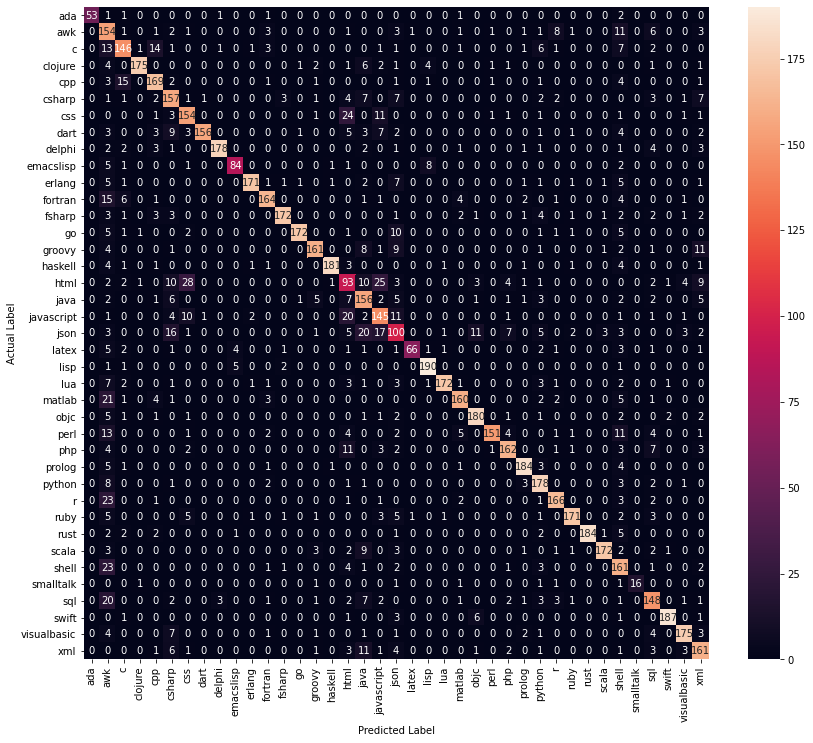

Classification Report for the best params : 
              precision    recall  f1-score   support

         ada       1.00      0.88      0.94        60
         awk       0.41      0.77      0.53       200
           c       0.77      0.73      0.75       200
     clojure       0.98      0.88      0.92       200
         cpp       0.81      0.84      0.83       200
      csharp       0.67      0.79      0.72       200
         css       0.73      0.77      0.75       200
        dart       0.99      0.78      0.87       200
      delphi       0.97      0.89      0.93       200
   emacslisp       0.89      0.82      0.85       103
      erlang       0.97      0.85      0.91       200
     fortran       0.88      0.82      0.85       200
      fsharp       0.95      0.86      0.90       200
          go       0.98      0.86      0.91       200
      groovy       0.89      0.81      0.85       200
     haskell       0.98      0.91      0.94       200
        html       0.47      0.47   

In [61]:
print("Confusion Matrix for best params :")
draw_confusion_matrix(Y_test, Y_pred, lbencoder.classes_)
print("Classification Report for the best params : ")
print(classification_report(Y_test, Y_pred, target_names=lbencoder.classes_))

In [18]:
# SGD

sgd_clf = SGDClassifier(early_stopping=True, n_jobs=-1, max_iter=1500, 
                         random_state=123, validation_fraction=0.2)
sgd_params = {'loss': ['hinge', 'modified_huber'], 
              'penalty': ['l2', 'elasticnet'], 
              'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1], 
              'epsilon': [0.01, 0.05, 0.1]}
Y_pred = classifier_optimizer(sgd_clf, sgd_params)

Mean fit time : 6.469s
Mean test time : 0.166s
Mean train score : 0.742
Mean CV score : 0.677
Best params :  {'alpha': 0.0001, 'epsilon': 0.01, 'loss': 'modified_huber', 'penalty': 'l2'}
Test score for best params : 0.829


In [80]:
run_results.loc[run_results.shape[0]]=['SGD Classifier', 6.5, 0.2, 
                                                0.742, 0.677, 0.829]

Confusion Matrix for best params :


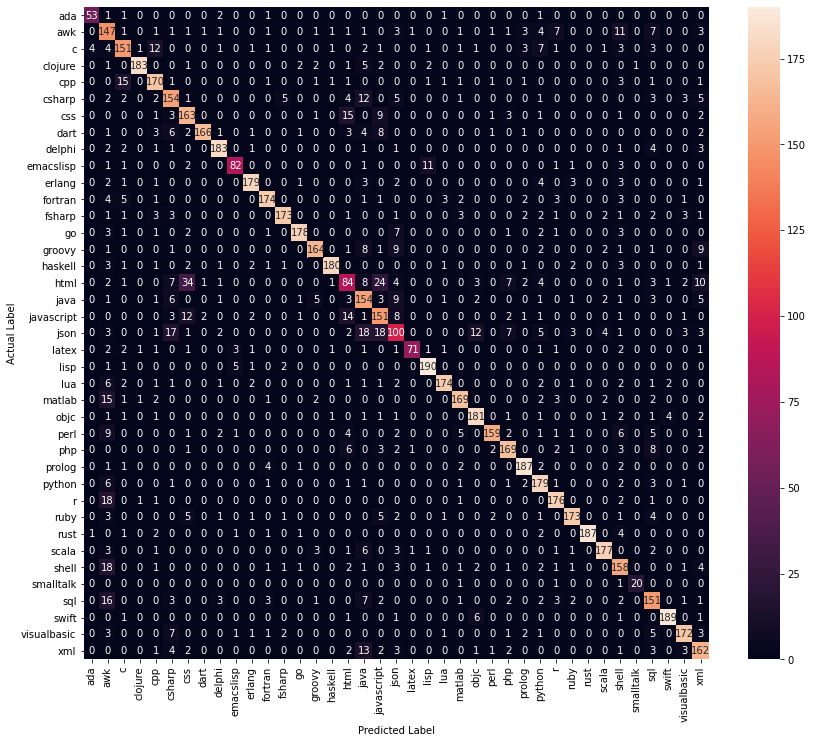

Classification Report for the best params : 
              precision    recall  f1-score   support

         ada       0.91      0.88      0.90        60
         awk       0.52      0.73      0.61       200
           c       0.78      0.76      0.77       200
     clojure       0.98      0.92      0.95       200
         cpp       0.81      0.85      0.83       200
      csharp       0.70      0.77      0.74       200
         css       0.71      0.81      0.76       200
        dart       0.98      0.83      0.90       200
      delphi       0.92      0.92      0.92       200
   emacslisp       0.88      0.80      0.84       103
      erlang       0.93      0.90      0.91       200
     fortran       0.91      0.87      0.89       200
      fsharp       0.94      0.86      0.90       200
          go       0.95      0.89      0.92       200
      groovy       0.91      0.82      0.86       200
     haskell       0.97      0.90      0.93       200
        html       0.57      0.42   

In [19]:
print("Confusion Matrix for best params :")
draw_confusion_matrix(Y_test, Y_pred, lbencoder.classes_)
print("Classification Report for the best params : ")
print(classification_report(Y_test, Y_pred, target_names=lbencoder.classes_))

In [20]:
# MNB

mnb_clf = MultinomialNB()
mnb_params = {'alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]}
Y_pred = classifier_optimizer(mnb_clf, mnb_params)

Mean fit time : 0.428s
Mean test time : 0.108s
Mean train score : 0.892
Mean CV score : 0.801
Best params :  {'alpha': 0.1}
Test score for best params : 0.810


In [81]:
run_results.loc[run_results.shape[0]]=['MultinomialNB Classifier', 0.4, 0.1, 
                                                0.892, 0.801, 0.810]

Confusion Matrix for best params :


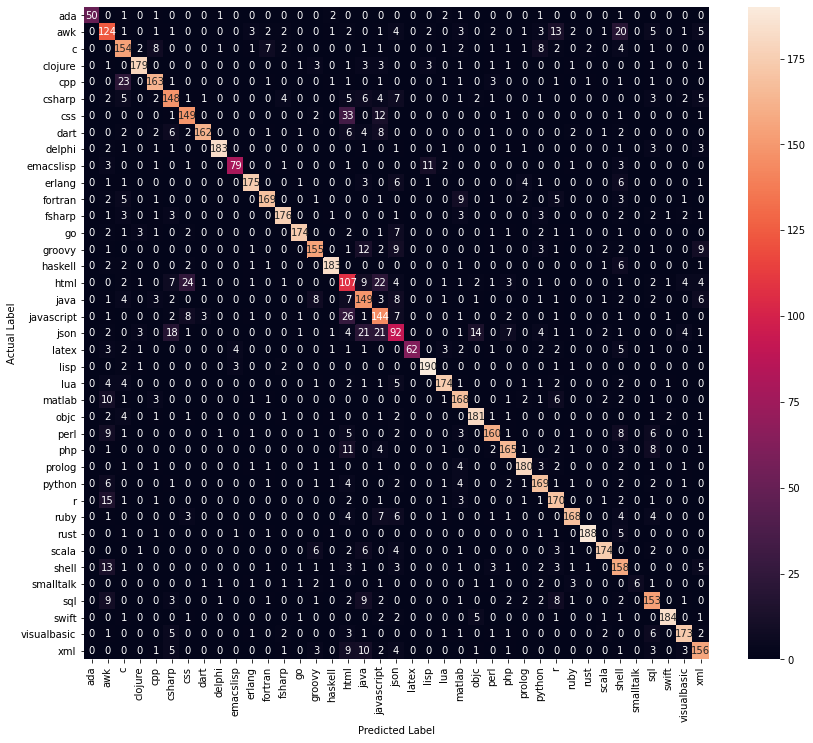

Classification Report for the best params : 
              precision    recall  f1-score   support

         ada       1.00      0.83      0.91        60
         awk       0.57      0.62      0.59       200
           c       0.69      0.77      0.73       200
     clojure       0.94      0.90      0.92       200
         cpp       0.84      0.81      0.83       200
      csharp       0.73      0.74      0.73       200
         css       0.76      0.74      0.75       200
        dart       0.96      0.81      0.88       200
      delphi       0.97      0.92      0.94       200
   emacslisp       0.91      0.77      0.83       103
      erlang       0.93      0.88      0.90       200
     fortran       0.90      0.84      0.87       200
      fsharp       0.91      0.88      0.90       200
          go       0.96      0.87      0.91       200
      groovy       0.83      0.78      0.80       200
     haskell       0.93      0.92      0.92       200
        html       0.44      0.54   

In [21]:
print("Confusion Matrix for best params :")
draw_confusion_matrix(Y_test, Y_pred, lbencoder.classes_)
print("Classification Report for the best params : ")
print(classification_report(Y_test, Y_pred, target_names=lbencoder.classes_))

In [19]:
# XGB

xgb_clf = XGBClassifier(random_state=123, n_jobs=-1)
# First we fix the objective param then, others
xgb_params = {'objective': ['binary:logistic', 'binary:hinge', 
                            'multi:softprob']}
Y_pred = classifier_optimizer(xgb_clf, xgb_params)

Mean fit time : 1482.767s
Mean test time : 5.809s
Mean train score : 0.869
Mean CV score : 0.792
Best params :  {'objective': 'binary:logistic'}
Test score for best params : 0.782


In [ ]:
# Since XGB is taking hours to train so we reduce the number of features to 20000 and 
# try again 

In [35]:
xgb_clf = XGBClassifier(objective='binary:logistic', random_state=123, n_jobs=-1)
# First we fix the objective param then, others
xgb_params = {'max_depth': [3,5,7], 'n_estimators':[50, 100, 200]}
# we limit the cv splits to 2 as xgboost takes hours to run
Y_pred = classifier_optimizer(xgb_clf, xgb_params, cv_limit=2)

Mean fit time : 1895.042s
Mean test time : 21.684s
Mean train score : 0.938
Mean CV score : 0.785
Best params :  {'max_depth': 5, 'n_estimators': 200}
Test score for best params : 0.797


In [82]:
run_results.loc[run_results.shape[0]]=['XGB Classifier**', 1895.0, 21.6, 
                                                0.938, 0.785, 0.797]

Confusion Matrix for best params :


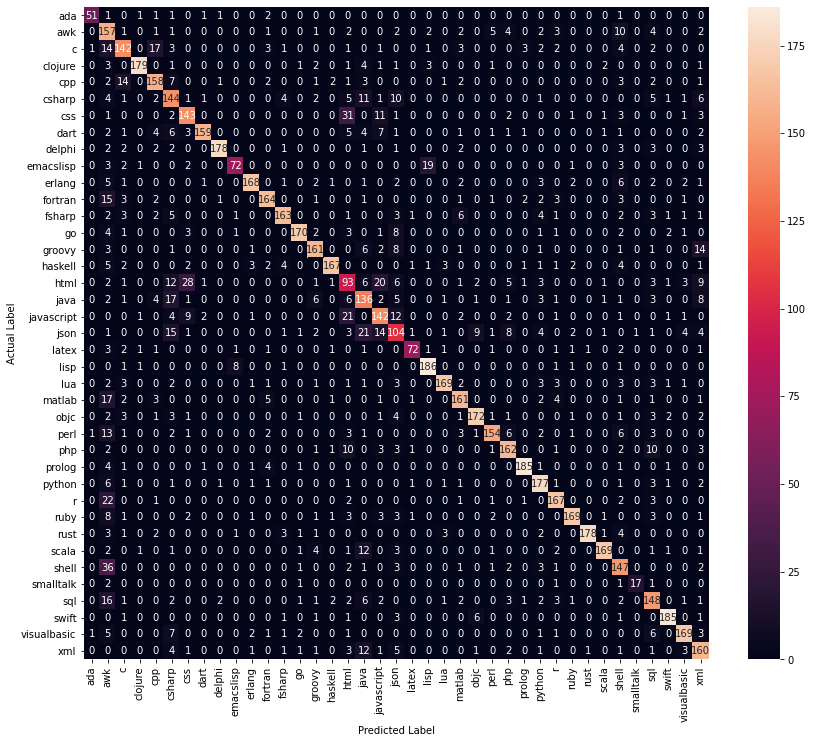

Classification Report for the best params : 
              precision    recall  f1-score   support

         ada       0.94      0.85      0.89        60
         awk       0.42      0.79      0.55       200
           c       0.74      0.71      0.72       200
     clojure       0.97      0.90      0.93       200
         cpp       0.79      0.79      0.79       200
      csharp       0.59      0.72      0.65       200
         css       0.72      0.71      0.72       200
        dart       0.96      0.80      0.87       200
      delphi       0.97      0.89      0.93       200
   emacslisp       0.86      0.70      0.77       103
      erlang       0.93      0.84      0.88       200
     fortran       0.87      0.82      0.84       200
      fsharp       0.90      0.81      0.85       200
          go       0.93      0.85      0.89       200
      groovy       0.84      0.81      0.82       200
     haskell       0.94      0.83      0.89       200
        html       0.46      0.47   

In [36]:
print("Confusion Matrix for best params :")
draw_confusion_matrix(Y_test, Y_pred, lbencoder.classes_)
print("Classification Report for the best params : ")
print(classification_report(Y_test, Y_pred, target_names=lbencoder.classes_))

In [85]:
run_results

,Classifier Name,Mean Fit Time(s),Mean Test Time(s),Mean Train Score,Mean CV Score,Best Test Score
0,Logistic Regression,44.128,0.102,0.875,0.738,0.824
1,KNeighbors Classifier,0.037,21.517,0.908,0.788,0.798
2,SVC Classifier,856.900,244.200,0.585,0.481,0.814
3,SGD Classifier,6.500,0.200,0.742,0.677,0.829
4,MultinomialNB Classifier,0.400,0.100,0.892,0.801,0.810
5,XGB Classifier**,1895.000,21.600,0.938,0.785,0.797
